In [18]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.init as init

import random

import pandas as pd
import wandb

from src.CPPN1 import CPPN1
from sklearn.model_selection import train_test_split

In [19]:
# wandb.init(project="CPPNsquared")

#### Hyperparameters

In [20]:

device = 'cuda'
num_steps = 300
batch_size = 8512
learn_rate = 0.001
momentum = 0.9
num_channels = 3
image_shape = (512, 644)

In [21]:
cppn1 = CPPN1()
cppn1.load_state_dict = torch.load('CPPN64.pt')
print(cppn1)
# feature maps trasfer learning 

CPPN1(
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fce1): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [22]:
# def weights_initialized_randomly(model):
#     for name, param in model.named_parameters():
#         # Check if parameter is trainable and requires gradients
#         if param.requires_grad:
#             # If any parameter has non-zero values, it's not randomly initialized
#             if torch.sum(param.data) != 0:
#                 return False
#     return True

# print(weights_initialized_randomly(cppn1))

#### Map spacial coordinates

In [23]:
parameter_info = []
fc1 = []
full_coords = []
full_weights = []

def spatial_coords(array, layer):

    coords = []
    row1 = []
    row2 = []
    for i in range(array.shape[0]):
        row2.append([layer+1, i])
    for i in range(array.shape[1]):
        row1.append([layer, i])
            
    array = array.flatten("C").tolist()
    # print(array)
    for i in row2:
        for j in row1:
            temp = []
            temp.extend(j)
            temp.extend(i)
            coords.append((temp))
    # coords_array = np.array(coords)
    # coords_array.astype(int)
    # output = np.column_stack((coords_array, array))

    # print(len(output))
    return coords, array
            
    # array.flatten()
    # return np.stack((array, coords))

index = 0
for name, param in cppn1.named_parameters():
    
    # print(name)
    if name.endswith(".weight"):
        
        # print(index)
        print(param)
        temp_layer = param.detach().numpy() # need to learn more about gradients and why they are required
        # print(temp_layer)

        temp_coords, temp_weights = spatial_coords(temp_layer, index)
        full_coords.extend(temp_coords)
        full_weights.extend(temp_weights)

        index += 1
        # print(fc1.shape[0])

print(full_coords)
print(full_weights)
    
# layer1_coords, layer1_weights = spatial_coords(fce1, 2)

# print(layer1_arragned)
    
    # getting seemingly random output here 
        

Parameter containing:
tensor([[ 0.4524,  0.4496],
        [ 0.2270, -0.4839],
        [-0.0498, -0.6977],
        [ 0.1635,  0.3944],
        [ 0.4895,  0.6573],
        [ 0.5413,  0.0643],
        [ 0.1344, -0.1044],
        [-0.0010,  0.1608],
        [-0.6974, -0.2690],
        [ 0.4033,  0.6000],
        [ 0.3990,  0.5580],
        [-0.1481,  0.1084],
        [ 0.6766,  0.3660],
        [ 0.2361, -0.1874],
        [ 0.1836,  0.2256],
        [ 0.1323,  0.5899],
        [-0.6283, -0.1444],
        [ 0.1328,  0.4281],
        [ 0.4458, -0.1766],
        [-0.5045,  0.4119],
        [ 0.3591, -0.0378],
        [ 0.5200, -0.5014],
        [-0.4174, -0.0409],
        [-0.0185,  0.1045],
        [-0.6195,  0.6916],
        [ 0.6241, -0.1273],
        [-0.1370, -0.5814],
        [-0.2048, -0.3816],
        [ 0.0071,  0.6182],
        [-0.2863, -0.6320],
        [-0.6057,  0.2808],
        [ 0.4557, -0.3544],
        [-0.2467, -0.4852],
        [ 0.3733,  0.2203],
        [ 0.1914, -0.2779]

#### Set up CPPN_squared

In [24]:
class CPPN_squared(nn.Module):
    
    def __init__(self):
      super(CPPN_squared, self).__init__()

      self.fc1 = nn.Linear(4, 16)

      self.fc2 = nn.Linear(16, 32)
      self.fce1 = nn.Linear(32, 32)
      # self.fce2 = nn.Linear(64,128)

      self.fc3 = nn.Linear(32, 1)     

      self.init_weights()
      
    def init_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Linear):
              # Initialize weights using Xavier initialization
              init.xavier_normal_(m.weight)
              # Initialize biases to zeros
              init.constant_(m.bias, 0)
    
    # defines forward pass
    def forward(self, x):

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fce1(x)
        x = F.relu(x)

        # x = self.fce2(x)
        # x = F.relu(x)

        x = self.fc3(x)
        # x = F.sigmoid(x)

        # returns the output of layer 3 after activation
        return x

In [25]:
CPPN_squared = CPPN_squared()
# wandb.watch(CPPN_squared)
CPPN_squared.to(device)
CPPN_squared.requires_grad_()

# optimiser = torch.optim.SGD(cppn.parameters(), lr=learn_rate, momentum=momentum)
optimiser = torch.optim.Adam(CPPN_squared.parameters(), lr=learn_rate)



criterion = nn.MSELoss(reduction='mean')
# criterion = nn.L1Loss(reduction = "mean")
# criterion = nn.CrossEntropyLoss(reduction='sum')

#### Normalization

In [26]:
def normalize_minus1_to_1(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = 2 * (tensor - min_vals) / (max_vals - min_vals) - 1
    return normalized_tensor

In [27]:
all_xy_coordinates = torch.tensor(full_coords, device=device, dtype=torch.float32)

# Normalize the coordinates matrix along each column
normalized_coords_matrix = normalize_minus1_to_1(all_xy_coordinates)
print(normalized_coords_matrix)

all_pixel_values = torch.tensor(full_weights, device=device, dtype=torch.float32)
all_pixel_values = (all_pixel_values + 1)/2
# all_pixel_values = torch.unsqueeze(all_pixel_values, 0)
print(all_pixel_values)

tensor([[-1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.9683, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -0.9683],
        [-1.0000, -0.9683, -1.0000, -0.9683],
        [-1.0000, -1.0000, -1.0000, -0.9365],
        [-1.0000, -0.9683, -1.0000, -0.9365],
        [-1.0000, -1.0000, -1.0000, -0.9048],
        [-1.0000, -0.9683, -1.0000, -0.9048],
        [-1.0000, -1.0000, -1.0000, -0.8730],
        [-1.0000, -0.9683, -1.0000, -0.8730],
        [-1.0000, -1.0000, -1.0000, -0.8413],
        [-1.0000, -0.9683, -1.0000, -0.8413],
        [-1.0000, -1.0000, -1.0000, -0.8095],
        [-1.0000, -0.9683, -1.0000, -0.8095],
        [-1.0000, -1.0000, -1.0000, -0.7778],
        [-1.0000, -0.9683, -1.0000, -0.7778],
        [-1.0000, -1.0000, -1.0000, -0.7460],
        [-1.0000, -0.9683, -1.0000, -0.7460],
        [-1.0000, -1.0000, -1.0000, -0.7143],
        [-1.0000, -0.9683, -1.0000, -0.7143],
        [-1.0000, -1.0000, -1.0000, -0.6825],
        [-1.0000, -0.9683, -1.0000

#### Split training and validation set


In [28]:

# train, test = train_test_split(normalized_coords_matrix, test_size= 0.2, random_state=42)
train_coords, val_coords, train_pixel_values, val_pixel_values = train_test_split(normalized_coords_matrix, all_pixel_values, test_size=0.1, random_state=42)
# import math
batch_size = int(batch_size * 0.9)

In [29]:
print(normalized_coords_matrix)

tensor([[-1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.9683, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -0.9683],
        [-1.0000, -0.9683, -1.0000, -0.9683],
        [-1.0000, -1.0000, -1.0000, -0.9365],
        [-1.0000, -0.9683, -1.0000, -0.9365],
        [-1.0000, -1.0000, -1.0000, -0.9048],
        [-1.0000, -0.9683, -1.0000, -0.9048],
        [-1.0000, -1.0000, -1.0000, -0.8730],
        [-1.0000, -0.9683, -1.0000, -0.8730],
        [-1.0000, -1.0000, -1.0000, -0.8413],
        [-1.0000, -0.9683, -1.0000, -0.8413],
        [-1.0000, -1.0000, -1.0000, -0.8095],
        [-1.0000, -0.9683, -1.0000, -0.8095],
        [-1.0000, -1.0000, -1.0000, -0.7778],
        [-1.0000, -0.9683, -1.0000, -0.7778],
        [-1.0000, -1.0000, -1.0000, -0.7460],
        [-1.0000, -0.9683, -1.0000, -0.7460],
        [-1.0000, -1.0000, -1.0000, -0.7143],
        [-1.0000, -0.9683, -1.0000, -0.7143],
        [-1.0000, -1.0000, -1.0000, -0.6825],
        [-1.0000, -0.9683, -1.0000

In [30]:
num_coords = all_xy_coordinates.shape[0]
coord_indexes = list(range(0, num_coords))
losses = []
img_list = []
running_loss = 0.0
best_loss = 10000000
best_val_loss = 10000000

# training loop
for i in range(num_steps):
    optimiser.zero_grad()
    CPPN_squared.zero_grad()

    # Sample a random batch of indexes from the list coord_indexes
    training_batch_indexes = torch.tensor(np.array(random.sample(range(0, train_coords.shape[0]), batch_size)))
    
    # Get batch of respective xy_coordiantes
    training_coords_batch = normalized_coords_matrix[training_batch_indexes]
    
    # And respective pixel values 
    pixel_values_batch = train_pixel_values[training_batch_indexes]
    pixel_values_batch = pixel_values_batch.unsqueeze(1)
    
    # Process data with model
    approx_pixel_values = CPPN_squared(training_coords_batch)
    
    # Calculate and track loss function
    loss = criterion(pixel_values_batch, approx_pixel_values)
    running_loss += loss.item()
    losses.append(loss.item())
    
    if i % 1 == 0:
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(CPPN_squared.state_dict(), 'CPPN2model.pt')
        print(f'step {i}, loss {running_loss:.3f}')
        # wandb.log({"loss": loss.item()})
        running_loss = 0.0

        #validation loop
        with torch.no_grad():
            val_loss = 0.0
            #should i iterate through them one by one or just do the whole thing?
            # for i in range(val_coords.shape[0]):
            #     val_output = CPPN_squared(val_coords[i])
            #     val_loss += criterion(val_pixel_values[i], val_output.unsqueeze(0)).item()
            val_output = CPPN_squared(val_coords)
            val_loss += criterion(val_pixel_values.unsqueeze(1), val_output).item()
            # val_loss /= val_coords.shape[0]

            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     best_model_weights = CPPN_squared.state_dict()
            #     torch.save(best_model_weights, 'best_CPPN2_weights.pt')
                
            print(f'Validation - Step {i}, loss {val_loss:.3f}')
            # wandb.log({"val_loss": val_loss})

            
    #Update model
    loss.backward()
    optimiser.step()
    # wandb.log({"final_weights": CPPN_squared.state_dict()})

step 0, loss 0.388
Validation - Step 0, loss 0.377
step 1, loss 0.355
Validation - Step 1, loss 0.345
step 2, loss 0.324
Validation - Step 2, loss 0.315
step 3, loss 0.295
Validation - Step 3, loss 0.287
step 4, loss 0.268
Validation - Step 4, loss 0.261
step 5, loss 0.242
Validation - Step 5, loss 0.236
step 6, loss 0.218
Validation - Step 6, loss 0.213
step 7, loss 0.195
Validation - Step 7, loss 0.191
step 8, loss 0.174
Validation - Step 8, loss 0.170
step 9, loss 0.155
Validation - Step 9, loss 0.151
step 10, loss 0.136
Validation - Step 10, loss 0.134
step 11, loss 0.120
Validation - Step 11, loss 0.118
step 12, loss 0.105
Validation - Step 12, loss 0.103
step 13, loss 0.091
Validation - Step 13, loss 0.090
step 14, loss 0.079
Validation - Step 14, loss 0.078
step 15, loss 0.069
Validation - Step 15, loss 0.068
step 16, loss 0.059
Validation - Step 16, loss 0.058
step 17, loss 0.052
Validation - Step 17, loss 0.050
step 18, loss 0.045
Validation - Step 18, loss 0.044
step 19, loss

In [31]:
with torch.no_grad():
    torch.set_printoptions(profile="full")
    prediction = CPPN_squared(normalized_coords_matrix)
    prediction = prediction.flatten(0)
    # prediction = prediction * 2 - 1
    print(prediction)

tensor([0.5883, 0.5908, 0.5818, 0.5843, 0.5762, 0.5786, 0.5713, 0.5737, 0.5664,
        0.5688, 0.5616, 0.5639, 0.5580, 0.5607, 0.5572, 0.5598, 0.5565, 0.5591,
        0.5557, 0.5588, 0.5554, 0.5585, 0.5553, 0.5582, 0.5551, 0.5579, 0.5556,
        0.5576, 0.5562, 0.5581, 0.5568, 0.5586, 0.5578, 0.5591, 0.5588, 0.5599,
        0.5598, 0.5607, 0.5607, 0.5616, 0.5617, 0.5624, 0.5627, 0.5632, 0.5637,
        0.5641, 0.5647, 0.5649, 0.5652, 0.5654, 0.5657, 0.5656, 0.5657, 0.5653,
        0.5657, 0.5651, 0.5653, 0.5646, 0.5647, 0.5638, 0.5640, 0.5629, 0.5633,
        0.5621, 0.5627, 0.5612, 0.5624, 0.5611, 0.5625, 0.5614, 0.5626, 0.5625,
        0.5639, 0.5638, 0.5652, 0.5652, 0.5666, 0.5665, 0.5680, 0.5679, 0.5694,
        0.5693, 0.5707, 0.5706, 0.5721, 0.5714, 0.5729, 0.5704, 0.5718, 0.5693,
        0.5708, 0.5683, 0.5697, 0.5672, 0.5694, 0.5670, 0.5681, 0.5657, 0.5664,
        0.5640, 0.5646, 0.5623, 0.5629, 0.5606, 0.5612, 0.5600, 0.5603, 0.5602,
        0.5605, 0.5604, 0.5607, 0.5606, 

In [32]:
print(all_pixel_values)

tensor([0.7262, 0.7248, 0.6135, 0.2581, 0.4751, 0.1512, 0.5817, 0.6972, 0.7447,
        0.8287, 0.7706, 0.5321, 0.5672, 0.4478, 0.4995, 0.5804, 0.1513, 0.3655,
        0.7017, 0.8000, 0.6995, 0.7790, 0.4260, 0.5542, 0.8383, 0.6830, 0.6181,
        0.4063, 0.5918, 0.6128, 0.5662, 0.7949, 0.1859, 0.4278, 0.5664, 0.7140,
        0.7229, 0.4117, 0.2477, 0.7059, 0.6796, 0.4811, 0.7600, 0.2493, 0.2913,
        0.4795, 0.4907, 0.5523, 0.1902, 0.8458, 0.8121, 0.4363, 0.4315, 0.2093,
        0.3976, 0.3092, 0.5036, 0.8091, 0.3568, 0.1840, 0.1972, 0.6404, 0.7278,
        0.3228, 0.3767, 0.2574, 0.6866, 0.6101, 0.5957, 0.3610, 0.6931, 0.2678,
        0.8500, 0.4395, 0.7345, 0.5892, 0.5458, 0.1589, 0.3854, 0.6189, 0.4670,
        0.2470, 0.2354, 0.5876, 0.3058, 0.2852, 0.8007, 0.6143, 0.3559, 0.2054,
        0.3084, 0.2321, 0.8417, 0.4562, 0.8165, 0.6082, 0.4396, 0.3670, 0.7850,
        0.2575, 0.4635, 0.1998, 0.5550, 0.4730, 0.5155, 0.7365, 0.4360, 0.2539,
        0.7450, 0.4203, 0.4433, 0.5373, 

Text(0.5, 1.0, 'target')

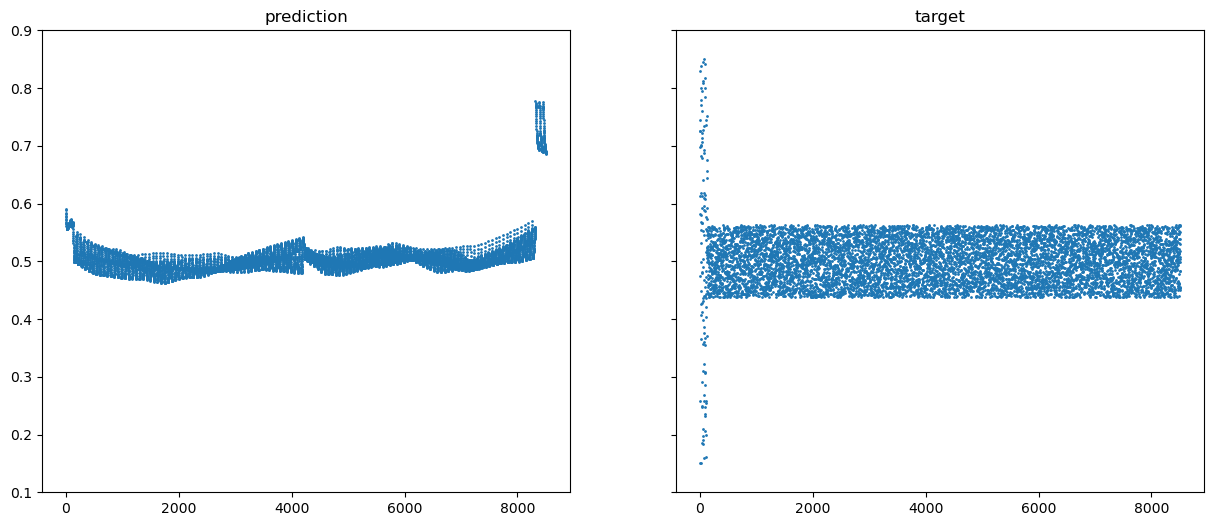

In [33]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (15, 6))
ax[0].set_ylim([0.1, 0.9])
x_values = np.arange(len(prediction.cpu().numpy()))

ax[0].scatter(x_values, prediction.cpu().numpy(), marker='o', s=1)
ax[0].set_title("prediction")
ax[1].scatter(x_values, all_pixel_values.cpu().numpy(), marker='o', s=1)
ax[1].set_title("target")

In [34]:
# prediction.mul_(2).sub_(1)
# index_tracker = 0
# with torch.no_grad():
#     for name, param in cppn.named_parameters():
#         # print(name)
#         if name.endswith(".weight"):
#             # print(param) 
#             temp_tensor = prediction[index_tracker:(index_tracker + param.numel())]
#             print(param.numel())
#             temp_tensor = torch.reshape(temp_tensor, param.shape)
#             print(temp_tensor)
#             param.data.copy_(temp_tensor)
#             # print(param.numel())
#             index_tracker += param.numel()
    
#             print(f"{name} replacement complete")

#     torch.save(cppn.state_dict(), "CPPNsquared_output.pt")